<a href="https://colab.research.google.com/github/misaelLS21/datos_masivos/blob/master/proyecto_6/DM_proyecto6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicación de busqueda de Tweets usando LSH.
Autor: Misael López Sánchez.

En este notebook realizamos la implementación de el algoritmo Local Sensitive Hashing (LSH) para realizar la labor de la busqueda del vecino más cercano en una base de datos para los tweets públicados durantes los debates presidenciales en **Estados Unidos** el código de este trabajo se encuentra disponible en el repositorio de [GitHub](https://github.com/misaelLS21/datos_masivos) y la fuente de datos se pueden consultar del siguiente link de la página de [Kaggle](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment)

In [0]:
#Importamos las bibliotecas para el analisis de la información
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import floor 
import nltk
import random
from sklearn.feature_extraction.text import CountVectorizer



In [3]:
'''
Descargamos las bibliotecas para poder hacer uso de lematizadores y 
tokenizar los textos de los tweets y crear bolsas de palabras que sirvan a 
manera de índices
'''

nltk.download(['punkt','averaged_perceptron_tagger','wordnet','stopwords'])
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet, stopwords
from nltk.corpus.reader.wordnet import NOUN, VERB, ADV, ADJ
from nltk.classify import SklearnClassifier

morphy_tag = {
    'JJ' : ADJ,
    'JJR' : ADJ,
    'JJS' : ADJ,
    'VB' : VERB,
    'VBD' : VERB,
    'VBG' : VERB,
    'VBN' : VERB,
    'VBP' : VERB,
    'VBZ' : VERB,
    'RB' : ADV,
    'RBR' : ADV,
    'RBS' : ADV
}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
''' 
Mandamos a llamar los datos directamente desde el repositorio de GitHub en donde
trabajaremos principalmente con los campos 'sentiment' & 'text' y mostramos
los datos en un DataFrame
'''


url = 'https://raw.githubusercontent.com/misaelLS21/datos_masivos/master/proyecto_6/Sentiment.csv'

#Cargamos los datos del archivo directamente desde nuestro repositorio de GitHub usando Pandas
dbTwitter = pd.read_csv(url,error_bad_lines=False)
pdTwitter = pd.DataFrame(dbTwitter)
pdTwitter[1:5]

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
1,2,Scott Walker,1.0,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0,yes,1.0,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona


# Introducción.
Lo que se muestra en el chunk anterior es una muestra de los valores que posee nuestra base de datos para los propositos de esta práctica los valoers sobre los cuales nos concentraremos serán los campos de **Sentiment** y **Text** como la base de datos es muy grande y hay muchos valoers disponible lo primero que hacemos des condentrarnos en analizar la información por sentimientos parecidos donde pre-clasificamos los datos de acuerdo con el sentimiento generlalizado en:

- Tweets Positivos
- Tweets Neutrales
- Tweets Negativos

La mayoría de los tweets son de tipo Negativos, así que serán estos sobre los cuales nos basaremos en la mayoria para realizar la clasificación y tokenización de la información.

In [5]:
'''
Leemos la longitud de la base de datos y vemos las caracteristicas de cada uno 
de los campos para ver el tipo de dato que representan
'''
print(dbTwitter.shape)
dbTwitter.info()

(13871, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13871 entries, 0 to 13870
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         13871 non-null  int64  
 1   candidate                  13775 non-null  object 
 2   candidate_confidence       13871 non-null  float64
 3   relevant_yn                13871 non-null  object 
 4   relevant_yn_confidence     13871 non-null  float64
 5   sentiment                  13871 non-null  object 
 6   sentiment_confidence       13871 non-null  float64
 7   subject_matter             13545 non-null  object 
 8   subject_matter_confidence  13871 non-null  float64
 9   candidate_gold             28 non-null     object 
 10  name                       13871 non-null  object 
 11  relevant_yn_gold           32 non-null     object 
 12  retweet_count              13871 non-null  int64  
 13  sentiment_gold             15 non-

In [0]:
#Extraemos de la base de datos los campos que nos interesan para trabajar
dataText = dbTwitter[['text','sentiment']]

Realizamos una representación pequeña del conjunto de datos que analizamos.

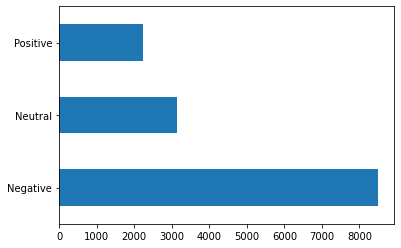

In [9]:
#Visualizamos como esta la distribucion de nuestro
dataText['sentiment'].value_counts().plot(kind="barh")

Nos desasemos de la información neutral y nos concentramos en uno de los polos el cual puede ya ser *Positivo* ó *Negativo*

In [0]:
dataText = dataText[dataText.sentiment != 'Neutral']
test_negative_tweets = dataText[dataText.sentiment == 'Negative'].shape[0]
test_positive_tweets = dataText[dataText.sentiment == 'Positive'].shape[0]

print("Tweets negativos:", test_negative_tweets)
print("Tweets positivos :",test_positive_tweets)

Tweets negativos: 8493
Tweets positivos : 2236


Transformamos los datos a un formato DataFrame donde nos concentramos nadamás en el texto de los tweets una vez ya pre-clasificada la información.

In [0]:
dataText_positive = dataText[dataText.sentiment == 'Positive']
dataText_negative = dataText[dataText.sentiment == 'Negative']

#Ahora sólo separamos los textos que es lo que realmente me importa
experimento = dataText_positive['text']
text_positive = pd.DataFrame(dataText_positive['text'])
text_negative = pd.DataFrame(dataText_negative['text'])


#Imprimimos las lontigudes
print("shape positivos", text_positive.shape)
print("shape negative", dataText_negative.shape)

#Ejemplo de los Tweets
text_negative[10:40]


shape positivos (2236, 1)
shape negative (8493, 2)


,text
21,RT @mchamric: RT “@TeaTraitors: #GOPDebate was...
22,RT @erinmallorylong: No *I* hate Planned Paren...
24,RT @MrPooni: Fox News trying to convince us yo...
25,#GOPDebate rankings: worst to be performance -...
26,RT @TheBaxterBean: Scott Walker's Abortion Ban...
27,"RT @feministabulous: It's not a competition, b..."
28,RT @mch7576: RT “@TeaTraitors: #GOPDebate was ...
29,RT @HillaryClinton: Watch the #GOPdebate? Bet ...
30,@fbhw they're going to need to borrow the trai...
31,RT @LisaVikingstad: Ted Cruz at the #GOPDebate...


In [0]:
#Preparamos el formato de las palabras para reconocer en inglés
stopwords_set = set(stopwords.words("english"))

In [0]:
def prepare_data(data):
    """
    @Input: recibe un DataFrame con los tweets
    @Output: Regresa una lista con los tweets limpiados eliminando etiquetas de tweet
           y caracteres como '@','#', etc además de eliminar toda aquella palabra con longitud
           menor a 3 letras para eliminar conectoers, etc
    """
    tweets = []
    for index, series in data.iterrows():
        text = series.text.lower()
        #words = text
        words = text.split()
        words = [word for word in words if len(word) > 3 and not word in stopwords_set and  'http' not in word and not word.startswith('@') and not word.startswith(' " ') and not word.startswith('#') and not word.startswith('.') and 'RT' != word]
        tweets.append((words))

    #Reagrupamos todo para que podamos crear las bolsas de palabras
    lista = []
    for k in range(len(tweets)):
      sentence = tweets[k]
      texto = ' '.join(sentence)
      lista.append(texto)

    return lista

Transformamos limpiando los tweets de los carácteres no deseados como las etiquetas y encabezados de tweets.

In [0]:
# Limpieza de los tweets
data_positive = prepare_data(text_positive)
data_negative = prepare_data(text_negative)

# Imprimimos las longitudes de los datos 
print("positivos",len(data_positive))
print("Negativos",len(data_negative))

#Ejemplo muestra
data_positive[10:20]


positivos 2236
Negativos 8493


['focus groupers said favorable view trump. after, positively.',
 'made first donation impressed performance.',
 "donald trump's campaign reveals important thing: twitter trolls real people. vote. scare eve…",
 'bill martha team first debate. debate ambush.',
 'several candidates express faith son, jesus christ.',
 'great start friday.',
 "elected, first president, i'll rescind every illegal unconstitutional executive order enacted pres. oba…",
 "even though super conservative reporter, actually like megyn kelly's interview style &amp; great",
 'credit joke goes someone else funny!',
 "simply incredible. last night's doubled previous record most-watched primary debate"]

In [0]:
def doc_a_tokens(doc):
  """
  @Input: Recibe una lista con Strings (Tweets) para leer elemento por elemento y lematizarlos y
          tokenizarlos
  @Output: Devuelve los elementos lematizados y tokenizados.

  """

  tagged = pos_tag(word_tokenize(doc.lower()))
  lemmatizer = WordNetLemmatizer()
  tokens = []
  for p,t in tagged:
    tokens.append(lemmatizer.lemmatize(p, pos=morphy_tag.get(t, NOUN)))
  return tokens

Volvemos a clasificar la información donde si queremos trabajar con los Tweets positivos lo especificamos en la variable **db_data** de lo contrario si queremos trabajar con los Tweets Positivos sólo descomentamos el la línea siguientes.

In [0]:
db_data = data_negative
#db_data = data_positive

Realizamos la partición de la información en una permutación aleatoria de consultas para después compar los documentos más parecidos con respecto a la base de Tweets usando consultas.

In [0]:
n = len(db_data)
perm  = np.random.permutation(n).astype(int)
n_ej = int(floor(n*0.95))

base = [db_data[i] for i in perm[:n_ej]]
consultas = [db_data[i] for i in perm[n_ej:]]

8068
425


Calculamos las bolsas de palabras tanto para los Tweets de la base como de la consulta usando *CountVectorizer* con las que trabajaremos más adelante.

In [0]:
#Calculamos las bolsas de palabras del conjunto CountVectorizer
docs_base = []
for d in base:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  tokens = doc_a_tokens(d)
  docs_base.append(' '.join(tokens))
  
v = CountVectorizer(stop_words='english', max_features=5000, max_df=0.8)

bolsas_base = v.fit_transform(docs_base)

In [0]:
docs_consultas = []
for d in consultas:
  d = d.replace('\n',' ').replace('\r',' ').replace('\t',' ')
  tokens = doc_a_tokens(d)
  docs_consultas.append(' '.join(tokens))

bolsas_consultas = v.transform(docs_consultas)

In [0]:
print("Dimension de la bolsa de palabras base",bolsas_base.shape)
print("Dimension de la bolsa de palabras base",bolsas_consultas.shape)

(8068, 5000)
(425, 5000)


# LSH
Función Local Sensitive Hash donde se instancia el código para realizar la inserción de las consultas similares dentro de tablas Hash.

In [0]:
class TablaLpLSH:
  def __init__(self, n_cubetas, t_tupla, dim, width, norma = 'l2'):
    self.n_cubetas = n_cubetas
    self.tabla = [[] for i in range(n_cubetas)]
    self.t_tupla = t_tupla
    self.dim = dim
    self.w = width

    if norma == 'l2':
      self.Amat = np.random.standard_normal((t_tupla, dim))
    elif norma == 'l1':
      self.Amat = np.random.standard_cauchy((t_tupla, dim))

    self.bvec = np.random.uniform(low=0, high=self.w, size=self.t_tupla)
    self.a = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
    self.b = np.random.randint(0, np.iinfo(np.int32).max, size=self.t_tupla)
    self.primo = 4294967291

  def __repr__(self):
    contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas)]
    return "<TablaHash :%s >" % ('\n'.join(contenido))

  def __str__(self):
    contenido = ['%d::%s' % (i, self.tabla[i]) for i in range(self.n_cubetas) if self.tabla[i]]
    return '\n'.join(contenido)

  def sl(self, x, i):
    return (self.h(x) + i) % self.n_cubetas

  def h(self, x):
    return x % self.primo

  def lphash(self, x):
    Amat = np.random.standard_cauchy((self.t_tupla,len(x)))
    bvec = np.random.uniform(low=0, high=self.w, size=self.t_tupla)
    prod = np.floor((Amat @ x.T + bvec) / self.w).astype(int)
    return np.sum(self.a * prod, dtype=np.ulonglong), np.sum(self.b * prod, dtype=np.ulonglong)
     
  def insertar(self, x, ident):
    lph, v2 = self.lphash(x)

    llena = True
    for i in range(self.n_cubetas):
      cubeta = int(self.sl(v2, i))
      if not self.tabla[cubeta]:
        self.tabla[cubeta].append(lph)
        self.tabla[cubeta].append([ident])
        llena = False
        break
      elif self.tabla[cubeta][0] == lph:
        self.tabla[cubeta][1].append(ident)
        llena = False
        break

    if llena:
      print('¡Error, tabla llena!')

  def buscar(self, x):
    mh, v2 = self.lphash(x)

    for i in range(self.n_cubetas):
      cubeta = int(self.sl(v2, i))
      if not self.tabla[cubeta]:
        return []
      elif self.tabla[cubeta][0] == mh:
        return self.tabla[cubeta][1]
        
    return []

In [0]:
n_tablas = 50
dim = bolsas_base.shape[1]
print(dim)
tablas = [TablaLpLSH(2**13, 1, dim, 50.0) for _ in range(n_tablas)]

5000


In [0]:

def csr_to_ldb(csr):
  ldb = [[] for _ in range(csr.shape[0])]
  coo = csr.tocoo()    
  for i,j,v in zip(coo.row, coo.col, coo.data):
    ldb[i].append(j)

  return ldb

In [0]:
ll_base = csr_to_ldb(bolsas_base)
ll_consultas = csr_to_ldb(bolsas_consultas)
print(len(ll_base))

8068


In [0]:
ll_base_arr = np.array([np.array(xi) for xi in ll_base])
ll_consultas_arr = np.array([np.array(xi) for xi in ll_consultas])
ll_base_arr.reshape(8068,1)

array([[array([2356,  482, 2619, 3642], dtype=int32)],
       [array([1028, 3054,  910, 3873, 3237], dtype=int32)],
       [array([ 910, 3873, 2887, 2081, 1905, 4390], dtype=int32)],
       ...,
       [array([4305, 3462, 1511,  514], dtype=int32)],
       [array([ 910, 3145, 4756, 3893], dtype=int32)],
       [array([1129, 4000], dtype=int32)]], dtype=object)

In [0]:
for i,x in enumerate(ll_base_arr):
  for t in range(n_tablas):
    tablas[t].insertar(x, i)

In [0]:
tablas[1]

<TablaHash :0::[0, [27, 72, 75, 89, 226, 260, 315, 883, 1649, 2249, 2284, 2313, 2432, 2655, 2793, 2846, 3579, 3754, 3869, 3904, 4340, 5126, 5169, 5193, 5336, 5426, 5501, 5887, 6541, 6640, 6811, 6912, 7015, 7088, 7111, 7141, 7422, 7573, 7857]]
1::[18446744056423039045, [1300, 1604, 1835, 2471, 3367, 4277, 4853, 5642, 6285, 6612, 7386]]
2::[282346371993, [1754, 2073, 5571, 5968, 7776, 7777]]
3::[18446742441094475466, [1340]]
4::[564692743986, [4625, 6046]]
5::[18446744060264486283, [179, 900, 3453, 4465, 6026]]
6::[847039115979, [2549, 4080, 4567, 4798, 5383, 7819]]
7::[1129385487972, [6094, 7907]]
8::[]
9::[]
10::[1411731859965, [7377]]
11::[]
12::[]
13::[]
14::[]
15::[]
16::[18446740831528082744, [4313]]
17::[]
18::[]
19::[]
20::[]
21::[18446740835369529982, [635, 1039]]
22::[]
23::[]
24::[]
25::[]
26::[]
27::[]
28::[]
29::[18446739225803137260, [5171]]
30::[]
31::[]
32::[]
33::[]
34::[]
35::[]
36::[18446740848814595315, [7797]]
37::[]
38::[18446742467984606132, [1362]]
39::[]
40::[]
4

In [0]:
vecs = []
for i,q in enumerate(ll_consultas_arr):
  dc = []
  for t in range(n_tablas):
      dc.extend(tablas[t].buscar(q))
  vecs.append(set(dc))

In [0]:
#Transofrmamos la bolsas a narray
bolsas_consultas_arr = np.array(bolsas_consultas.toarray())
bolsas_base_arr = np.array(bolsas_base.toarray())



<class 'numpy.ndarray'>


(8068, 5000)

In [0]:
def distancia_euclidiana(x, y):   
  return np.sqrt(np.sum((x - y)**2))

def fuerza_bruta(ds, qs, fd):
  medidas = np.zeros(ds.shape[0])
  for i,x in enumerate(ds):
    medidas[i] = fd(qs, x)

  return np.sort(medidas), np.argsort(medidas)



dists = []
orden = []
for i,q in enumerate(bolsas_consultas_arr):
  ld = list(vecs[i])
  if ld:
    m,o = fuerza_bruta(bolsas_base_arr[ld], q, distancia_euclidiana)
    dists.append(m)
    orden.append([ld[e] for e in o])
  else:
    dists.append([])
    orden.append([])

In [0]:
print(dists[4])
print(orden[4])

[3.46410162 3.46410162 3.46410162 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.74165739 3.74165739 3.74165739 3.74165739 3.74165739
 3.74165739 3.74165739 3.74165739 3.74165739 3.74165739 3.74165739
 3.74165739 3.74165739 3.74165739 3.74165739 3.87298335 3.87298335
 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335
 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335
 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335
 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335
 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335 4.
 4.         4.         4.         4.         4.         4.
 4.         4.         4.         4.         4.         4.
 4.         4.         4.         4.         4.         4.
 4.12310563 4.12310563 4.12310563 4.12310563 4.12310563 4.12310563
 4.12310563 4.12310563 4.12

In [0]:
print(consultas[4])

cruz: need commander chief makes clear join isis signing death warrant.


In [0]:
print(base[list(orden[5])[0]])

carson, carson, carson: dammit man! words racism white supremacy audience!


In [0]:
def fuerza_bruta(ds, qs, fd):
  medidas = np.zeros(ds.shape[0])
  for i,x in enumerate(ds):
    medidas[i] = fd(qs, x)

  return np.sort(medidas)[::-1], np.argsort(medidas)[::-1]

sims = []
orden = []
for i,q in enumerate(bolsas_consultas_arr):
  ld = list(vecs[i])
  if ld:
    s,o = fuerza_bruta(bolsas_base_arr[ld], q, distancia_euclidiana)
    sims.append(s)
    orden.append([ld[e] for e in o])
  else:
    sims.append([])
    orden.append([])

In [0]:
print(sims[5])
print(orden[5])

[4.35889894 4.35889894 4.12310563 4.         4.         3.87298335
 3.87298335 3.87298335 3.87298335 3.87298335 3.87298335 3.74165739
 3.74165739 3.74165739 3.74165739 3.74165739 3.74165739 3.74165739
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128
 3.60555128 3.60555128 3.60555128 3.60555128 3.60555128 3.46410162
 3.46410162 3.46410162 3.46410162 3.46410162 3.46410162 3.46410162
 3.46410162 3.46410162 3.46410162 3.46410162 3.46410162 3.46410162
 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479
 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479
 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479
 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479 3.31662479
 3.31662479 3.31662479 3.31662479 3.31662479 3.16227766 3.16227766
 3.16227766 3.16227766 3.16227766 3.16227766 3.16227766 3.16227766
 3.16227766 3.16227766 3.16227766 3.16227766 3.16227766 3.16227766
 3.16227766 3.16227766 3.16227766 3.16227766 3.16227766 3.1622

In [0]:
print(len(sims))

425


In [0]:
vecs